### Assessing the distibution of tax-4, osm-9 and tax-4/osm-9 double null strains relative to the null reference conditon, symmetric DMSO
We wanted to compare the relative position of the mutant strains' response to symetric DMSO to the N2 response. In a previous analysis comparing N2 to symmetric DMSO, we determined that the minimum number of worms deposited onto each plate should be 150. We came to this conclusion by performing a bootstapping analysis of varying sample sizes to determine at what point the sample size showed the least amount of variation in response due to chance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import dabest as db
import pathlib as plb
from scipy.stats import norm
import statistics

### Reading in and cleaning up the data

In [2]:
GN = pd.read_csv('/Users/Emily/Documents/S1F2/GN1077_xs.csv', usecols = ['DMSO']).rename(columns = {'DMSO':'GN1077'})
PR = pd.read_csv('/Users/Emily/Documents/S1F2/PR678_xs.csv', usecols = ['DMSO']).rename(columns = {'DMSO':'PR678'})
CX = pd.read_csv('/Users/Emily/Documents/S1F2/CX10_xs.csv', usecols = ['DMSO']).rename(columns = {'DMSO':'CX10'})
N2 = pd.read_csv('/Users/Emily/Documents/S1/S1_xs3.csv', usecols = ['DMSO']).rename(columns = {'DMSO':'N2'})
strains = ['N2', 'GN1077', 'CX10', 'PR678']

In [3]:
mut_xs = pd.merge(pd.merge(pd.merge(N2, GN, right_index=True, left_index=True),CX, right_index=True, left_index=True), 
                  PR, right_index=True, left_index=True)
mut_xs['Compound'] = 'DMSO'
mut_xs

,N2,GN1077,CX10,PR678,Compound
0,-1.893137,-15.142851,-1.724854,-20.715138,DMSO
1,-11.672137,-12.488908,-15.884814,-20.086483,DMSO
2,-14.423804,-6.563295,-10.547538,-24.119231,DMSO
3,-9.047470,9.524776,-6.554956,-15.397905,DMSO
4,-2.676304,24.108740,-10.880225,-16.680117,DMSO
...,...,...,...,...,...
993,20.458863,NaN,NaN,NaN,DMSO
994,-18.762970,NaN,NaN,NaN,DMSO
995,-20.943137,NaN,NaN,NaN,DMSO
996,-9.894137,NaN,NaN,NaN,DMSO


#### Generating a swarm plot of worm locations relative to DMSO

In [4]:
def pswarm(df, strain):
    #for_swarm = pooled_refs_df.copy()
    #for_swarm['Compound'] = 'DMSO'
    fig, ax = plt.subplots(figsize=(2,4) )
    ax = sns.swarmplot(data=df, size=1)

    ax.set_ylim(-35,35)
    ax.set(xlabel=strain, ylabel="Worm location in assay arena (mm)")
    sns.despine()
    fig.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
    #fig.savefig('C:/Users/Emily/Desktop/NPScreen_figs/' + strain + '_DMSO.svg', dpi=300)

[None, None, None, None]

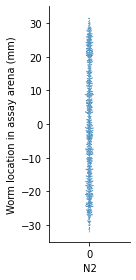

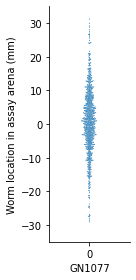

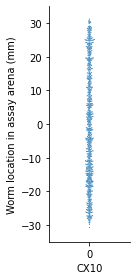

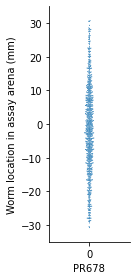

In [5]:
[pswarm(mut_xs[s], s) for s in strains]

### Bootstrapping steps
1. Randomly sample groups of 50, 100, 150 ... 300, 350 worms -> hold in an array
2. Calculate chemotaxis index for each group of worms
3. Iterate random sampling and CI calculation 100 times -> Hold CIs in an array
4. Plot

In [6]:
# We need to generate a function to calculate the chemotaxis indices for each bootstrapped sample. The chemotaxis index
# will be used to assess where the variance for the model levels off

def calc_chemotaxis_index(worms):
    
    ## Assign features to zones of the plate
    left_area_boundary = (-3.5) #Need to generate a more accurate boundary value
    #print(left_area_boundary)
    right_area_boundary = (3.5) #Need to generate a more accurate boundary value
    #print(right_area_boundary)

    left_side_worms = worms[worms['X'] <= left_area_boundary]
    #middle_w = worms[worms['centroid-1'] < right_area_boundary]
    #middle_worms = middle_w[middle_w['centroid-1'] >left_area_boundary]
    right_side_worms = worms[worms['X'] >= right_area_boundary]

    ## Calculate chemotaxis index
    worms_in_left_region = len(left_side_worms)
    #worms_in_middle_region = len(middle_worms)
    worms_in_right_region = len(right_side_worms)
    total_worms_found = len(right_side_worms) + len(left_side_worms)
    #print('Left; ' + str(worms_in_left_region) + '   Right: ' + str(worms_in_right_region))

    

    try:
        chemotaxis_index = ((worms_in_left_region - worms_in_right_region) 
                        / (worms_in_left_region + worms_in_right_region))
        return chemotaxis_index

    except ZeroDivisionError:
        return 0
    

### Creating the bootstrapping function 

In [7]:

CI_df_V = pd.DataFrame(columns= ['CI', 'N', 'Strain'])
def bstrap(strain, vals):
    sdf = pd.DataFrame(columns= ['CI', 'N', 'Strain'])
    # Creating a np array of all worm locations from 2103 dataset to be used for resampling
    vals[~np.isnan(vals)]
    x_dmso = np.asarray(vals)
    np.random.seed(12345)
    
    sample_sizes = [50, 100, 150, 200, 250, 300, 350]
    n = 100
    
    for j in sample_sizes:

        CIs = []
        #for n in sample_sizes:
        i=0
        while i < 100:

            resample = np.random.choice(a=x_dmso, size=j, replace=True)
            resample_df_long = pd.DataFrame(resample, columns=['X'])
            CI = (calc_chemotaxis_index(resample_df_long), j)

            CIs.append(CI)
            i += 1
        df = pd.DataFrame(CIs, columns=['CI', 'N'])
        df['Strain'] = strain
        sdf = sdf.append(df)

    return sdf

In [8]:
#iterating through the data for all mutant strains
for s in strains:
    CI_df_V = CI_df_V.append(bstrap(s, mut_xs[s]))


### Creating a function to plot the data so that we can loop trhought it for all strains

In [9]:
def bxplt(df):
    #for_swarm = pooled_refs_df.copy()
    #for_swarm['Compound'] = 'DMSO'
    fig, ax = plt.subplots(figsize=(10,4))
    ax = sns.boxplot(data=df, x= 'N', y='CI', hue='Strain', palette="Blues_r", boxprops=dict(alpha=.7), )
    ax = sns.stripplot(x="N", y="CI", data=df, size=2, color='.2')
    ax.set_ylim(-1,1)
    #ax.set(xlabel=strain, ylabel="Worm location in assay arena (mm)")
    sns.despine()
    fig.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
    #fig.savefig('C:/Users/Emily/Desktop/NPScreen_figs/' + s + '_DMSO_box.svg', dpi=300)

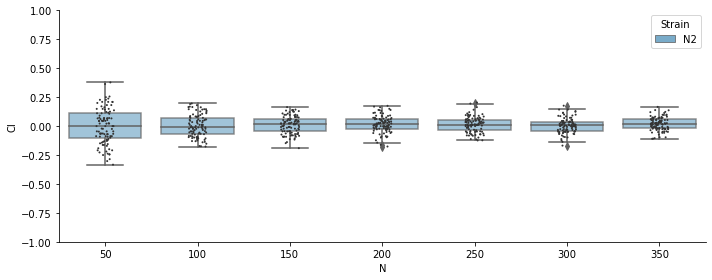

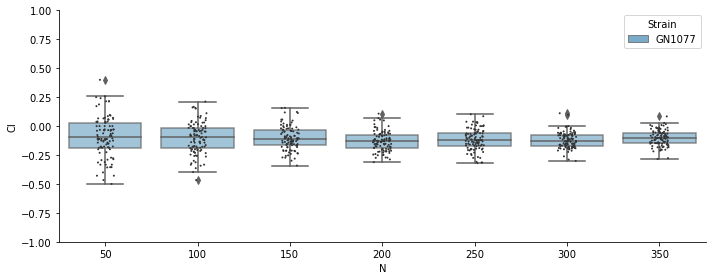

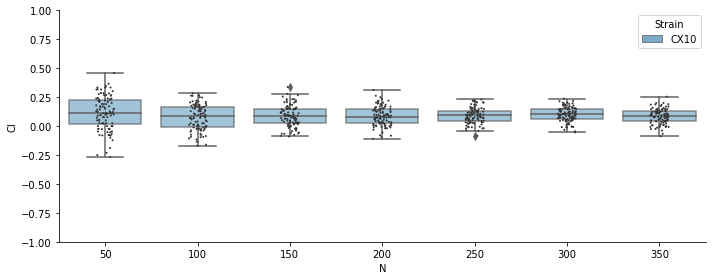

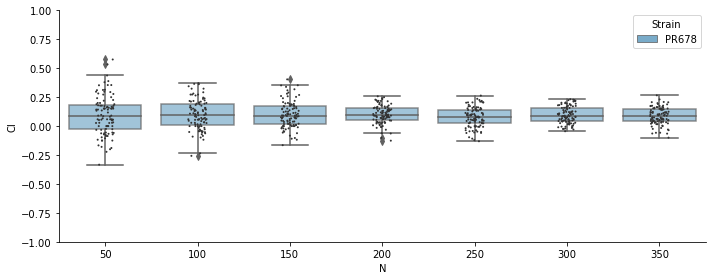

In [18]:
for s in strains:
    strn = CI_df_V.loc[CI_df_V['Strain'] == s]
    bxplt(strn)

We need to create a long dataframe to calculate and plot the variance for each strain

In [10]:
#CI_df_long
V = CI_df_V.groupby(['N', 'Strain']).agg(np.var).reset_index()
V= V.rename(columns = {'CI': 'Variance'})

### This is the version of the figure that is currently being used in the manuscript. The variance is plotted above the boxplots for each group.

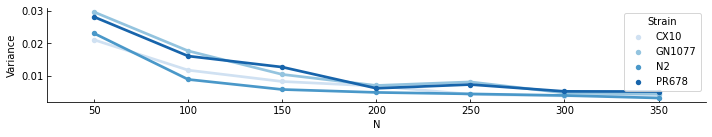

In [21]:

#sns.set(style="white")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 2))

axes = sns.pointplot(x='N', y = 'Variance', hue = 'Strain', data=V, palette='Blues', ax=axes, markers='.', s=1)
#axes = sns.pointplot(x='N', y='CXV', data=CXv, color = '#0570b0', ax=axes, markers='.')
#axes = sns.pointplot(x='N', y='PRV', data=PRv, color = '#034e7b', ax=axes, markers='.')

axes.set(xlabel="N", ylabel="Variance")
axes.tick_params(axis='both', tickdir='in')


#axes.get_legend().remove()
sns.despine(offset=10)
plt.rcParams['svg.fonttype'] = 'none'
fig.tight_layout()
#fig.savefig('C:/Users/Emily/Desktop/NPScreen_figs/all_variance_bstrap.svg', dpi=300)

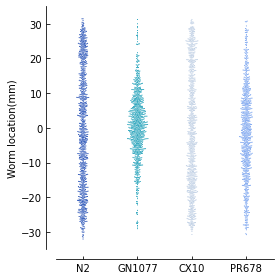

In [18]:
fig, ax = plt.subplots(figsize=(4,4) )
ax = sns.swarmplot(data=mut_xs, size=1, palette=palette)

ax.set_ylim(-35,35)
ax.set(ylabel="Worm location(mm)")
ax.tick_params(axis='both', tickdir='in')
sns.despine(offset = 10)
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig('C:/Users/Emily/Desktop/NPScreen_figs/swarm_DMSO.svg', dpi=300)

In [12]:
N2 = CI_df_V.loc[CI_df_V['Strain']=='N2']


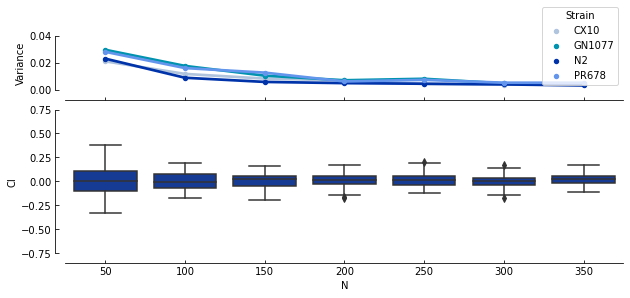

In [22]:

palette = {
    'N2': '#0033aa',
    'PR678': '#6495ed',
    'CX10': '#b0c4de',
    'GN1077': '#0093af',
}

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True, gridspec_kw={'height_ratios': [.75, 2]})

axes[0] = sns.pointplot(x='N', y='Variance', hue='Strain', data=V, palette=palette, ax=axes[0], markers='.')
axes[0].set(xlabel="", ylabel="Variance")
axes[0].set_ylim(0,.04)
axes[0].tick_params(axis='both', tickdir='in')


axes[1] = sns.boxplot(data=N2, x= 'N', y='CI', hue='Strain', palette=palette)
axes[1].set_ylim(-.75,.75)
axes[1].tick_params(axis='both', tickdir='in')
axes[1].get_legend().remove()

sns.despine(offset=10)
#fig.savefig('C:/Users/Emily/Desktop/NPScreen_figs/dmso_vplots.svg', dpi=300)